<a href="https://colab.research.google.com/github/chltjs1921/2024_modeling_practice/blob/main/10_replicate_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

replicate https://arxiv.org/abs/2010.11929

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.3.1+cu121
0.18.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056 (from 1)
Receiving objects: 100% (4056/4056), 646.90 MiB | 23.92 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
from going_modular.going_modular import data_setup
from torchvision import transforms

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

In [7]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image_batch.shape, image.shape, label_batch.shape, label.shape

(torch.Size([32, 3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([32]),
 torch.Size([]))

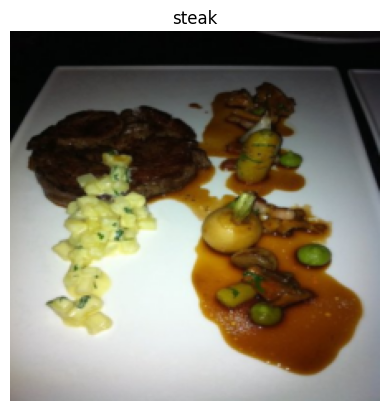

In [9]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

Input, output, layers, blocks, model  
Input>model(=block(= layer조합) 조합)>output  

  
Embedding = learnable representation

In [10]:
#input shape: (224, 224, 3) H=W=224 C=3
#N = H*W/P^(2)
#output shape: (N,P^(2)*C)
H = 224
W = 224
C = 3
P = 16

N = int(H*W/P**2)
N

196

In [11]:
input_shape = (H, W, C)
output_shape = (N, P**2*C)
input_shape, output_shape

((224, 224, 3), (196, 768))

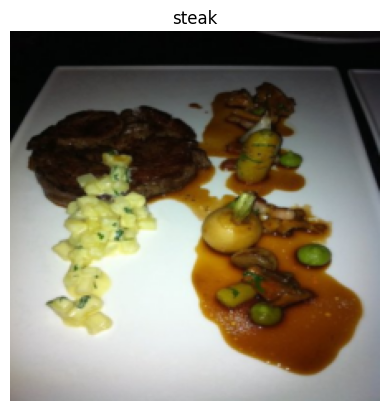

In [12]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [13]:
img_permute = image.permute(1, 2, 0) #to H,W,C
img_permute.shape

torch.Size([224, 224, 3])

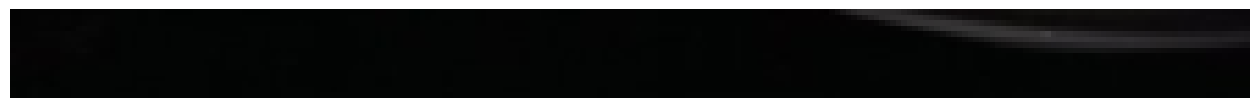

In [14]:
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(img_permute[0:patch_size, :, :])
plt.axis(False)
plt.show()

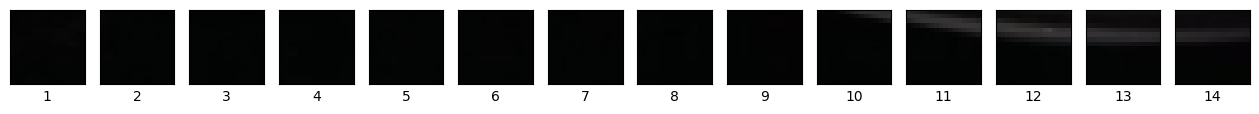

In [15]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "image size must be divisible by patch size"

fig, axs = plt.subplots(nrows=1, ncols=img_size//patch_size, sharex=True, sharey=True, figsize=(patch_size, patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
    #print(patch)
    axs[i].imshow(img_permute[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

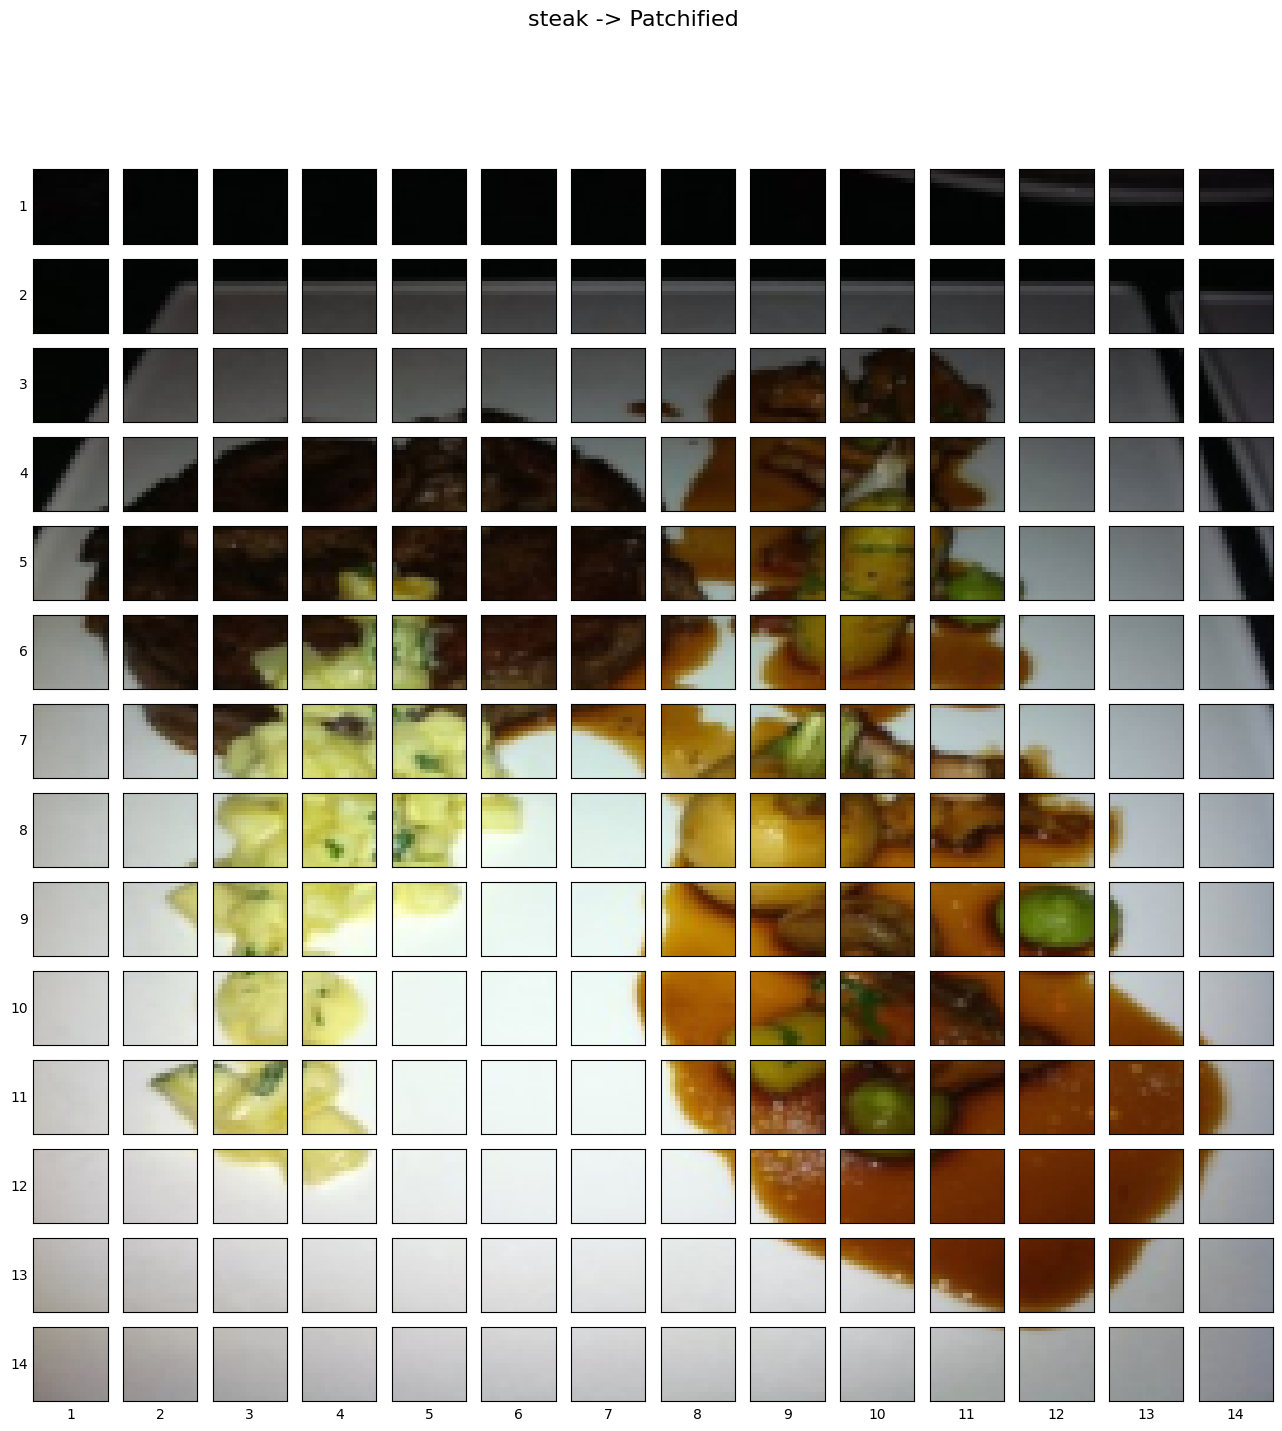

In [16]:
#img split
fig, axs = plt.subplots(nrows=img_size//patch_size, ncols=img_size//patch_size, sharex=True, sharey=True, figsize=(patch_size, patch_size))

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i][j].imshow(img_permute[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])
        axs[i][j].set_xlabel(j+1)
        axs[i][j].set_ylabel(i+1, rotation='horizontal', horizontalalignment='right', verticalalignment='center')
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].label_outer()
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [17]:
#img to patch
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=patch_size, stride=patch_size, padding=0)


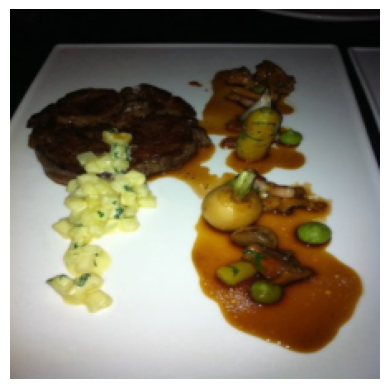

In [18]:
plt.imshow(img_permute)
plt.axis(False)
plt.show()

In [19]:
img_out_of_conv2d = conv2d(image.unsqueeze(0))
img_out_of_conv2d.shape

torch.Size([1, 768, 14, 14])

In [20]:
#flatten
img_out_of_conv2d.flatten(start_dim=2).shape

torch.Size([1, 768, 196])

In [21]:
nn.Flatten(start_dim=2)(img_out_of_conv2d).shape

torch.Size([1, 768, 196])

In [22]:
flatten_layer = nn.Flatten(start_dim=2)
flatten_layer(img_out_of_conv2d).shape

torch.Size([1, 768, 196])

In [23]:
img_out_of_conv2d_flatten = flatten_layer(img_out_of_conv2d)
img_out_of_conv2d_flatten.permute(0, 2, 1).shape

torch.Size([1, 196, 768])

In [85]:
class IMG_TO_PATCH(nn.Module):
    def __init__(self, patch_size: int, in_channels: int=3, embed_dim: int=768, img_size: int=224):
        super().__init__()
        self.patch_size = patch

        self.conv2d = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim,
                                kernel_size=patch_size, stride=patch_size, padding=0)
        self.flatten = nn.Flatten(start_dim=2)

    def forward(self, x):
        if x.dim == 3:
            x = x.unsqueeze(0)
        else:
            x =x
        x = self.conv2d(x)
        x = self.flatten(x)
        x = x.permute(0, 2, 1)
        return x

In [25]:
patch_embedding = IMG_TO_PATCH(patch_size=patch_size)
patch_embedding(image).shape

torch.Size([1, 196, 768])

In [26]:
#class token embedding
batch_size = 1
embedding_dimension = 768
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [27]:
# Add the class token embedding to the front of the patch embedding
# add >> torch.cat
patch_embedding_img_with_class_token = torch.cat((class_token, patch_embedding(image)), dim=1)
patch_embedding_img_with_class_token.shape

torch.Size([1, 197, 768])

In [28]:
patch_embedding(image)

tensor([[[ 6.0506e-03, -1.8822e-02, -4.4564e-04,  ...,  8.6146e-03,
          -1.1675e-02, -6.8922e-03],
         [-1.1864e-03, -1.8924e-02, -4.9534e-03,  ...,  1.0722e-02,
          -1.7478e-02, -1.9409e-03],
         [ 1.9762e-03, -1.8294e-02, -6.8974e-03,  ...,  7.8899e-03,
          -1.4575e-02, -4.1680e-03],
         ...,
         [ 1.4863e-01, -1.0519e-02, -1.9007e-01,  ...,  2.3753e-01,
           2.0301e-01,  6.7714e-01],
         [ 1.3318e-01,  1.2253e-04, -1.8133e-01,  ...,  2.2029e-01,
           1.8101e-01,  6.5395e-01],
         [ 1.2357e-01, -3.1429e-03, -1.9727e-01,  ...,  2.2176e-01,
           1.8638e-01,  6.1483e-01]]], grad_fn=<PermuteBackward0>)

In [29]:
class_token

Parameter containing:
tensor([[[ 1.5318e+00, -4.2394e-03, -1.7233e+00, -3.6815e-01, -3.3033e-01,
          -3.0241e-01,  9.7868e-01, -1.3376e+00, -6.9663e-02, -7.8845e-01,
           4.9386e-01,  8.1927e-01, -7.3835e-01,  1.2071e+00,  1.9947e+00,
          -1.2591e+00, -4.7224e-01, -4.4589e-01,  1.0141e-03, -1.6182e+00,
          -9.8701e-01, -4.9944e-01,  1.9029e-01, -1.3245e-01,  1.0644e-01,
          -1.3703e+00,  4.9006e-01,  6.8459e-01, -7.0462e-01,  1.9442e-02,
           3.6801e-01, -4.0689e-01, -5.6478e-01, -1.0631e+00,  2.1130e+00,
           1.8816e-01, -2.0750e+00,  8.2805e-01,  6.6758e-02,  5.8387e-01,
           1.7866e+00,  1.9789e+00,  1.4167e+00,  2.0689e-01,  1.0453e+00,
          -7.8011e-01,  1.8883e+00,  1.3979e+00, -2.2629e-01, -5.5743e-01,
           1.4348e+00,  2.5561e-01, -2.8255e-01,  1.0839e+00,  1.7204e+00,
           2.2406e-01, -1.5595e+00,  1.8996e-01, -6.2175e-01,  8.3852e-01,
          -8.7795e-01, -9.9184e-01, -6.5664e-01, -3.6207e-01, -4.4439e-01,
   

In [30]:
patch_embedding_img_with_class_token

tensor([[[ 1.5318e+00, -4.2394e-03, -1.7233e+00,  ...,  1.9113e+00,
          -1.1386e+00, -2.5952e-01],
         [ 6.0506e-03, -1.8822e-02, -4.4564e-04,  ...,  8.6146e-03,
          -1.1675e-02, -6.8922e-03],
         [-1.1864e-03, -1.8924e-02, -4.9534e-03,  ...,  1.0722e-02,
          -1.7478e-02, -1.9409e-03],
         ...,
         [ 1.4863e-01, -1.0519e-02, -1.9007e-01,  ...,  2.3753e-01,
           2.0301e-01,  6.7714e-01],
         [ 1.3318e-01,  1.2253e-04, -1.8133e-01,  ...,  2.2029e-01,
           1.8101e-01,  6.5395e-01],
         [ 1.2357e-01, -3.1429e-03, -1.9727e-01,  ...,  2.2176e-01,
           1.8638e-01,  6.1483e-01]]], grad_fn=<CatBackward0>)

In [31]:
#create position embedding
num_patches = int(img_size/patch_size)**2

embedding_dim = patch_embedding_img_with_class_token.shape[-1]

position_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim), requires_grad=True)
position_embedding.shape

torch.Size([1, 197, 768])

In [32]:
position_embedding

Parameter containing:
tensor([[[ 0.0630, -0.3110,  0.7701,  ..., -1.0361, -1.7209,  1.3005],
         [-0.4620, -0.9473, -1.2995,  ..., -1.2304,  1.8055, -0.8679],
         [-0.5340,  0.1595, -1.0927,  ...,  0.1702,  0.3660,  2.7476],
         ...,
         [ 1.2638, -0.7283,  1.4681,  ..., -1.0067,  0.6837, -1.1033],
         [ 2.0086, -0.5032,  0.0745,  ...,  0.5933,  0.1683,  1.0450],
         [-1.5478, -0.8145,  0.5761,  ...,  1.5383,  0.2226,  0.1538]]],
       requires_grad=True)

In [33]:
patch_position_embedding = patch_embedding_img_with_class_token + position_embedding
patch_position_embedding, patch_position_embedding.shape

(tensor([[[ 1.5949, -0.3153, -0.9533,  ...,  0.8752, -2.8596,  1.0410],
          [-0.4560, -0.9662, -1.2999,  ..., -1.2218,  1.7938, -0.8748],
          [-0.5351,  0.1406, -1.0977,  ...,  0.1810,  0.3485,  2.7456],
          ...,
          [ 1.4124, -0.7388,  1.2780,  ..., -0.7691,  0.8867, -0.4262],
          [ 2.1418, -0.5030, -0.1068,  ...,  0.8136,  0.3493,  1.6989],
          [-1.4242, -0.8177,  0.3789,  ...,  1.7600,  0.4090,  0.7686]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

In [34]:
class IMG_TO_PATCH_WITH_EMBEDDINGS(nn.Module):
    def __init__(self, patch_size: int=16, img_size: int=224, in_channels: int=3, embed_dim: int=768):
        super().__init__()
        num_patches = int(img_size/patch_size)**2
        self.patch_size = patch_size
        self.conv2d = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim,
                                kernel_size=patch_size, stride=patch_size, padding=0)
        self.flatten = nn.Flatten(start_dim=2)
        self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True)
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches+1, embed_dim), requires_grad=True)

    def forward(self, x):
        if x.dim == 3:
            x = x.unsqueeze(0)
        x = self.conv2d(x)
        x = self.flatten(x)
        x = x.permute(0, 2, 1)
        x = torch.cat((self.class_token, x), dim=1)
        x = x + self.position_embedding
        return x

In [35]:
img_patch_position_embedding=IMG_TO_PATCH_WITH_EMBEDDINGS()
img_patch_position_embedding(image).shape

torch.Size([1, 197, 768])

In [36]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self, embed_dim: int=768, num_heads: int=12):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim

        self.ln = nn.LayerNorm(embed_dim)
        self.msa = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)

    def forward(self, x):
        x = self.ln(x)
        #x = x.permute(1, 0, 2)
        x, _ = self.msa(query=x, key=x, value=x)
        return x

In [37]:
msa = MultiheadSelfAttentionBlock()
msa(patch_position_embedding).shape

torch.Size([1, 197, 768])

In [38]:
msa(img_patch_position_embedding(image)).shape

torch.Size([1, 197, 768])

In [39]:
class MLP(nn.Module):
    def __init__(self, embed_dim: int=768, mlp_dim: int=3072, dropout:float=0.1):
        super().__init__()
        self.lnorm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.gelu = nn.GELU()
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=mlp_dim)
        self.fc2 = nn.Linear(in_features=mlp_dim, out_features=embed_dim)

    def forward(self, x):
        x = self.lnorm(x)
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [40]:
mlp_block = MLP()
mlp_block(msa(img_patch_position_embedding(image))).shape

torch.Size([1, 197, 768])

In [41]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim: int=768, num_heads: int=12, mlp_dim: int=3072, dropout: float=0.1):
        super().__init__()
        self.msa = MultiheadSelfAttentionBlock(embed_dim=embed_dim, num_heads=num_heads)
        self.mlp = MLP(embed_dim=embed_dim, mlp_dim=mlp_dim, dropout=dropout)

    def forward(self, x):
        x = x + self.msa(x)
        x = x + self.mlp(x)
        return x

In [42]:
trans = TransformerEncoderBlock()
trans(img_patch_position_embedding(image)).shape

torch.Size([1, 197, 768])

In [45]:
summary(trans, (1, 197, 768), col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=['var_names'],
        verbose=0, device="cpu")

Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]             [1, 197, 768]             --                        True
├─MultiheadSelfAttentionBlock (msa)                [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm (ln)                              [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─MultiheadAttention (msa)                    --                        [1, 197, 768]             2,362,368                 True
├─MLP (mlp)                                        [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm (lnorm)                           [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─Linear (fc1)                                [1, 19

In [46]:
torch_trans = torch.nn.TransformerEncoderLayer(d_model=768, nhead=12,
                                               dim_feedforward=3072, dropout=0.1, activation='gelu',
                                               batch_first=True, norm_first=True)

torch_trans

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [47]:
summary(torch_trans, (1, 197, 768), col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=['var_names'],
        verbose=0, device="cpu")

Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]             [1, 197, 768]             7,087,872                 True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [56]:
(img_size*img_size)//patch_size**2

196

In [71]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [86]:
class ViT(nn.Module):
    def __init__(self, img_size: int=224, patch_size: int=16, num_transformer_layers: int=12, embed_dim: int=768, in_channels:int=3,
                 num_heads: int=12, mlp_dim: int=3072, num_classes: int=1000, mlp_dropout: float=0.1, embed_dropout: float=0.1):
        super().__init__()

        assert img_size % patch_size == 0, "image size must be divisible by patch size"

        self.num_patches = (img_size*img_size)//patch_size**2

        self.class_embedding = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True)
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches+1, embed_dim), requires_grad=True)
        self.embedding_dropout = nn.Dropout(embed_dropout)
        self.patch_embedding = IMG_TO_PATCH(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embed_dim=embedding_dim)
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(embed_dim=embed_dim,
                                      num_heads=num_heads, mlp_dim=mlp_dim, dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = x + self.position_embedding
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = x[:, 0]
        x = self.mlp_head(x)
        return x

In [87]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))
#random_image_tensor .shape
# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.3854,  0.4115,  0.5742]], grad_fn=<AddmmBackward0>)

In [88]:
summary(vit, (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=['var_names'],
        verbose=0, device="cpu")

Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Trainable
ViT (ViT)                                          [1, 3, 224, 224]          [1, 3]                    152,064                   True
├─IMG_TO_PATCH (patch_embedding)                   [1, 3, 224, 224]          [1, 196, 768]             --                        True
│    └─Conv2d (conv2d)                             [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   True
│    └─Flatten (flatten)                           [1, 768, 14, 14]          [1, 768, 196]             --                        --
├─Dropout (embedding_dropout)                      [1, 197, 768]             [1, 197, 768]             --                        --
├─Sequential (transformer_encoder)                 [1, 197, 768]             [1, 197, 768]             --                        True
│    └─TransformerEncoderBlock (0)                 [1, 197, 7

In [89]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(), lr=0.001)

In [90]:
from going_modular.going_modular import engine

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.4924 | train_acc: 0.4141 | test_loss: 1.4030 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.6804 | train_acc: 0.2852 | test_loss: 1.3669 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.4887 | train_acc: 0.4258 | test_loss: 1.0509 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.1794 | train_acc: 0.2695 | test_loss: 1.1410 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1455 | train_acc: 0.4180 | test_loss: 1.0313 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.1346 | train_acc: 0.2891 | test_loss: 1.0912 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1199 | train_acc: 0.2969 | test_loss: 1.1194 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1542 | train_acc: 0.4180 | test_loss: 1.1815 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1864 | train_acc: 0.3047 | test_loss: 1.0066 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.3211 | train_acc: 0.2617 | test_loss: 1.2447 | test_acc: 0.1979


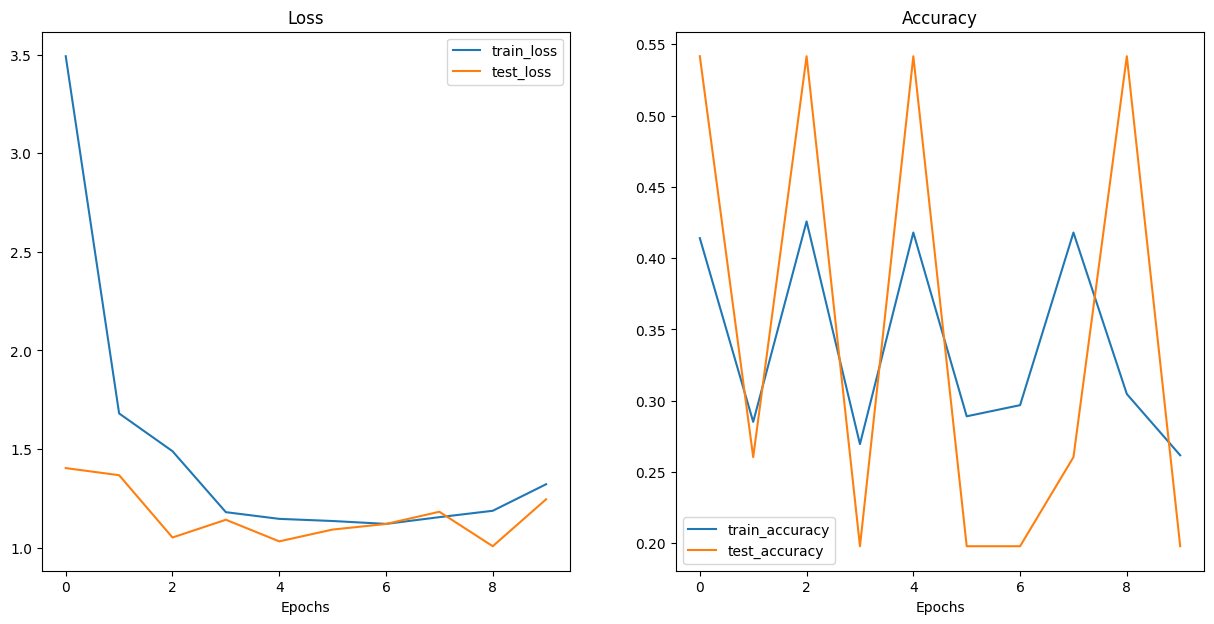

In [91]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [94]:
#get pre-trained model
pretraied_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
model = torchvision.models.vit_b_16(weights=pretraied_weights).to(device)

In [96]:
summary(model, (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=['var_names'],
        verbose=0, device="cpu")

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]          [1, 1000]                 768                       True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   True
├─Encoder (encoder)                                          [1, 197, 768]             [1, 197, 768]             151,296                   True
│    └─Dropout (dropout)                                     [1, 197, 768]             [1, 197, 768]             --                        --
│    └─Sequential (layers)                                   [1, 197, 768]             [1, 197, 768]             --                        True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]             [1, 197, 768]             7,087,872           

In [97]:
for param in model.parameters():
    param.requires_grad = False

In [98]:
summary(model, (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=['var_names'],
        verbose=0, device="cpu")

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]          [1, 1000]                 768                       False
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]          [1, 768, 14, 14]          (590,592)                 False
├─Encoder (encoder)                                          [1, 197, 768]             [1, 197, 768]             151,296                   False
│    └─Dropout (dropout)                                     [1, 197, 768]             [1, 197, 768]             --                        --
│    └─Sequential (layers)                                   [1, 197, 768]             [1, 197, 768]             --                        False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]             [1, 197, 768]             (7,087,872)     

In [101]:
#update classifier
set_seeds()
model.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [102]:
summary(model, (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=['var_names'],
        verbose=0, device="cpu")

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]          [1, 3]                    768                       Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]          [1, 768, 14, 14]          (590,592)                 False
├─Encoder (encoder)                                          [1, 197, 768]             [1, 197, 768]             151,296                   False
│    └─Dropout (dropout)                                     [1, 197, 768]             [1, 197, 768]             --                        --
│    └─Sequential (layers)                                   [1, 197, 768]             [1, 197, 768]             --                        False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]             [1, 197, 768]             (7,087,872)   

In [105]:
#get automated transforms

pretrained_transforms = pretraied_weights.transforms()
pretrained_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [106]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_transforms,
    batch_size=32
)

In [108]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=model,
                       train_dataloader=train_dataloader_pretrained,
                       test_dataloader=test_dataloader_pretrained,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8473 | train_acc: 0.6758 | test_loss: 0.5352 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3547 | train_acc: 0.9414 | test_loss: 0.3261 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.2425 | train_acc: 0.9492 | test_loss: 0.2662 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1775 | train_acc: 0.9492 | test_loss: 0.2538 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1467 | train_acc: 0.9570 | test_loss: 0.2428 | test_acc: 0.9186
Epoch: 6 | train_loss: 0.1336 | train_acc: 0.9727 | test_loss: 0.2276 | test_acc: 0.8873
Epoch: 7 | train_loss: 0.1098 | train_acc: 0.9766 | test_loss: 0.2103 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.0981 | train_acc: 0.9766 | test_loss: 0.2052 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.0960 | train_acc: 0.9766 | test_loss: 0.2026 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.0803 | train_acc: 0.9844 | test_loss: 0.1984 | test_acc: 0.9176


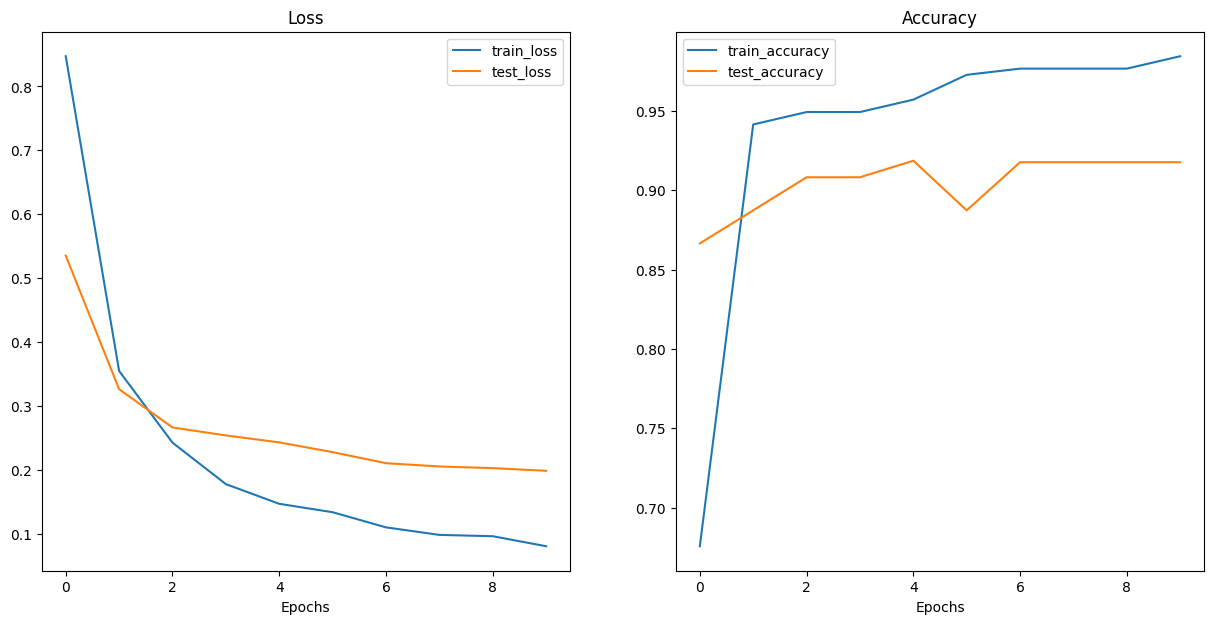

In [109]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [110]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=model,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [111]:
from pathlib import Path

model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size/1024/1024
print(f"Model size: {model_size:.2f} MB")

Model size: 327.37 MB


data/pizza_steak_sushi/04-pizza-dad.jpeg already exists, skipping download.


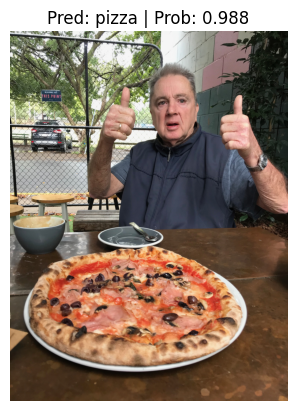

In [113]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)